# Dask

<img src="images/dask_logo.jpg">

- process data that doesn't fit into memory by breaking it into blocks and specifying task chains
- parallelize execution of tasks across cores and even nodes of a cluster
- move computation to the data rather than the other way around, to minimize communication overheads

http://dask.pydata.org/en/latest/

In [1]:
import dask
import dask.multiprocessing

## Define two slow functions

In [2]:
from time import sleep

def slowinc(x, delay=1):
    sleep(delay)
    return x + 1

def slowadd(x, y, delay=1):
    sleep(delay)
    return x + y

In [3]:
%%time
x = slowinc(1)
y = slowinc(2)
z = slowadd(x, y)

CPU times: user 1.14 ms, sys: 132 µs, total: 1.28 ms
Wall time: 3 s


## Parallelize with dask.delayed

- Functions wrapped by `dask.delayed` don't run immediately, but instead put those functions and arguments into a task graph. 
- The result is computed separately by calling the `.compute()` method.

In [4]:
from dask import delayed

In [5]:
x = delayed(slowinc)(1)
y = delayed(slowinc)(2)
z = delayed(slowadd)(x, y)

In [6]:
%%time
z.compute()

CPU times: user 4.2 ms, sys: 3.56 ms, total: 7.76 ms
Wall time: 2.01 s


5

## Dask graph

- Contains description of the calculations necessary to produce the result. 
- The z object is a lazy Delayed object. This object holds everything we need to compute the final result. We can compute the result with .compute() as above or we can visualize the task graph for this value with .visualize().

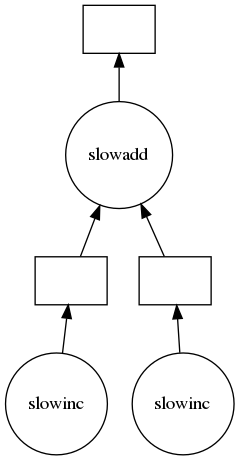

In [7]:
z.visualize()

## Parallelize a loop

In [8]:
%%time
data = list(range(8))

results = []

for x in data:
    y = slowinc(x)
    results.append(y)

total = sum(results)
total

CPU times: user 7.17 ms, sys: 413 µs, total: 7.59 ms
Wall time: 8.01 s


36

### Exercise 8.1

- Parallelize this by appending the delayed `slowinc` calls to the list `results`.
- Display the graph of `total` computation
- Compute time elapsed for the computation.

## Decorator

It is also common to see the delayed function used as a decorator. Same example:

In [9]:
%%time

@dask.delayed
def slowinc(x, delay=1):
    sleep(delay)
    return x + 1

@dask.delayed
def slowadd(x, y, delay=1):
    sleep(delay)
    return x + y

x = slowinc(1)
y = slowinc(2)
z = slowadd(x, y)
z.compute()

CPU times: user 4.35 ms, sys: 596 µs, total: 4.95 ms
Wall time: 2 s


5

## Control flow
-  Delay only some functions, running a few of them immediately. This is helpful when those functions are fast and help us to determine what other slower functions we should call. 
- In the example below we iterate through a list of inputs. If that input is even then we want to call `half`. If the input is odd then we want to call `odd_process`. This iseven decision to call `half` or `odd_process` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [10]:
from random import randint
import dask.delayed

def half(x):
    sleep(1)
    return x // 2

def odd_process(x):
    sleep(1)
    return 3*x+1

def is_even(x):
    return not x % 2

data = [randint(0,100) for i in range(8)]
data

[23, 91, 52, 46, 37, 4, 49, 36]

### Exercise 8.2
- Parallelize the sequential code above using dask.delayed
- You will need to delay some functions, but not all
- Visualize and check the computed result

### Exercise 8.3
- Parallelize the hdf5 conversion from json files
- Create a function `convert_to_hdf`
- Use dask.compute function on delayed calls of the funtion created list
- Is it really  faster as expected ?

Hint: Read [Delayed Best Practices](http://dask.pydata.org/en/latest/delayed-best-practices.html)

In [11]:
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_data(name, where):
    datadir = os.path.join(where,name)
    if not os.path.exists(datadir):
       print("Extracting data...")
       tar_path = os.path.join(where, name+'.tgz')
       with tarfile.open(tar_path, mode='r:gz') as data:
          data.extractall(where)
            
extract_data('daily-stock','data') # this function call will extract json files

In [12]:
import os, sys
from glob import glob
import pandas as pd
import json

here = os.getcwd() # get the current directory
filenames = sorted(glob(os.path.join(here,'data', 'daily-stock', '*.json')))

In [13]:
def read( fn ):
    with open(fn) as f:
        return [json.loads(line) for line in f]
    
def convert(data):
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, os.path.join(here,'data'))
    return

for fn in filenames:  
    data = read( fn)
    convert(data)
    

/usr/share/miniconda3/envs/big-data/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'big-data'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [14]:
%ls data/daily-stock/*.h5

data/daily-stock/aet.h5   data/daily-stock/bwa.h5  data/daily-stock/jpm.h5
data/daily-stock/afl.h5   data/daily-stock/ge.h5   data/daily-stock/luv.h5
data/daily-stock/aig.h5   data/daily-stock/hal.h5  data/daily-stock/met.h5
data/daily-stock/al.h5    data/daily-stock/hp.h5   data/daily-stock/pcg.h5
data/daily-stock/amgn.h5  data/daily-stock/hpq.h5  data/daily-stock/tgt.h5
data/daily-stock/avy.h5   data/daily-stock/ibm.h5  data/daily-stock/usb.h5
data/daily-stock/b.h5     data/daily-stock/jbl.h5  data/daily-stock/xom.h5


## Read multiple files with Dask Arrays

In [15]:
from tqdm import tqdm
from PIL import Image
import dask
import dask.delayed as delayed
import dask.array as da
from glob import glob
import h5py as h5
import numpy as np

Download the file from https://github.com/MMAS/https://github.com/MMASSD/datasets

In [16]:
extract_data('fvalues','data') 

Extracting data...


FileNotFoundError: [Errno 2] No such file or directory: 'data/fvalues.tgz'

In [ ]:
filenames = sorted(glob("data/*.h5"))
filenames[:5], len(filenames)

In [ ]:
def scale(x) :
    "Scale field to 0-255 levels"
    return np.uint8(255*(x-np.min(x)) / (np.max(x)-np.min(x)))

In [ ]:
def read_frame( filepath ):
    " Create image from the `dataset` of h5 file `filepath` "
    with h5.File(filepath, "r") as f:
        z = f.get("values")
        return scale(z)

In [ ]:
%%time

serial_frames = [read_frame(fn) for fn in filenames]

In [ ]:
def display_image( frame ):
    return Image.fromarray(frame)

display_image(read_frame(filenames[-1]))

In [ ]:
from ipywidgets import interact, IntSlider

def display_sequence(iframe):
    
    return Image.fromarray(serial_frames[iframe])
    
interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(serial_frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

In [ ]:
lazy_read = delayed(read_frame)
lazy_frames = [lazy_read(fn) for fn in filenames]

In [ ]:
sample = lazy_frames[500].compute() 

In [ ]:
display_image(sample) 

In [ ]:
%%time

parallel_frames = dask.compute(*lazy_frames)

In [ ]:
from ipywidgets import interact, IntSlider

def display_sequence(iframe):
    
    return Image.fromarray(parallel_frames[iframe])
    
interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(parallel_frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

In [ ]:
arrays = [da.from_delayed(lazy_read,# Construct a small Dask array
                          dtype=sample.dtype,   # for every lazy value
                          shape=sample.shape)
          for lazy_read in lazy_frames]

In [ ]:
dask_frames = da.stack(arrays, axis=0)  # concatenate arrays along first axis 

In [ ]:
dask_frames 

In [ ]:
dask_frames = dask_frames.rechunk((100, 257, 257))   

In [ ]:
sample = dask_frames[-1,:,:]
sample 

In [ ]:
display_image(sample.compute())

In [ ]:
from ipywidgets import interact, IntSlider

def display_sequence(iframe):
    
    return Image.fromarray(dask_frames[iframe,:,:].compute())
    
interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(dask_frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

Everytime you move the slider, it will read the corresponding file and load the frame. That's why you need to wait a little to get your image. You load image one by one and you can handle a very large amount of images.

In [ ]:
interact(display_sequence, 
iframe=IntSlider(min=0,
max=len(dask_frames)-1,
step=1,
value=0,
continuous_update=True))